In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

###Preprocessing

In [ ]:
df = pd.read_csv('Cases_US_None.csv')
df.head()

,country,province,date,day_since100,case_cnt,death_cnt,new_hospitalization,total_hospitalization,new_icu,total_icu,new_recovered,total_recovered
0,US,NaN,2020-01-22,-42,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,US,NaN,2020-01-23,-41,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2,US,NaN,2020-01-24,-40,2,0,NaN,NaN,NaN,NaN,NaN,NaN
3,US,NaN,2020-01-25,-39,2,0,NaN,NaN,NaN,NaN,NaN,NaN
4,US,NaN,2020-01-26,-38,5,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.index = pd.PeriodIndex(df.date, freq='D')
df.head()

,country,province,date,day_since100,case_cnt,death_cnt,new_hospitalization,total_hospitalization,new_icu,total_icu,new_recovered,total_recovered
date,,,,,,,,,,,,
2020-01-22,US,NaN,2020-01-22,-42,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,US,NaN,2020-01-23,-41,1,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,US,NaN,2020-01-24,-40,2,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,US,NaN,2020-01-25,-39,2,0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,US,NaN,2020-01-26,-38,5,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dfUS= df.loc[df.country == "US"].copy()
dfUS = dfUS.drop(["country", "province", "new_hospitalization", "total_hospitalization", "new_icu", "total_icu", "new_recovered", "total_recovered"], axis = 1)

In [ ]:
case_cnt = dfUS['case_cnt']
case_daily = [case_cnt[0]]
death_cnt = dfUS['death_cnt']
death_daily = [death_cnt[0]]
for i in range(1,len(case_cnt)):
  death_daily.append(death_cnt[i]-death_cnt[i-1])
  case_daily.append(case_cnt[i]-case_cnt[i-1])
dfUS['case_daily'] = case_daily 
dfUS['death_daily'] = death_daily 

In [ ]:
dfUS.head()

,date,day_since100,case_cnt,death_cnt,case_daily,death_daily
date,,,,,,
2020-01-22,2020-01-22,-42,1,0,1,0
2020-01-23,2020-01-23,-41,1,0,0,0
2020-01-24,2020-01-24,-40,2,0,1,0
2020-01-25,2020-01-25,-39,2,0,0,0
2020-01-26,2020-01-26,-38,5,0,3,0


In [ ]:
idx = dfUS.index[dfUS['death_daily'] > 0].tolist()
dfB = dfUS.loc[idx]
dfB.head()

,date,day_since100,case_cnt,death_cnt,case_daily,death_daily
date,,,,,,
2020-02-29,2020-02-29,-4,24,1,8,1
2020-03-02,2020-03-02,-2,53,6,23,5
2020-03-03,2020-03-03,-1,73,7,20,1
2020-03-04,2020-03-04,0,104,11,31,4
2020-03-05,2020-03-05,1,174,12,70,1


In [ ]:
dfB.date = pd.DatetimeIndex(dfB.date)
dfB["timeIndex"] = dfB.date - dfB.date.min()
dfB["timeIndex"] =  dfB["timeIndex"]/np.timedelta64(1, 'D')
dfB["timeIndex"] = dfB["timeIndex"].round(0).astype(int)
dfB.head()

,date,day_since100,case_cnt,death_cnt,case_daily,death_daily,timeIndex
date,,,,,,,
2020-02-29,2020-02-29,-4,24,1,8,1,0
2020-03-02,2020-03-02,-2,53,6,23,5,2
2020-03-03,2020-03-03,-1,73,7,20,1,3
2020-03-04,2020-03-04,0,104,11,31,4,4
2020-03-05,2020-03-05,1,174,12,70,1,5


###Modeling

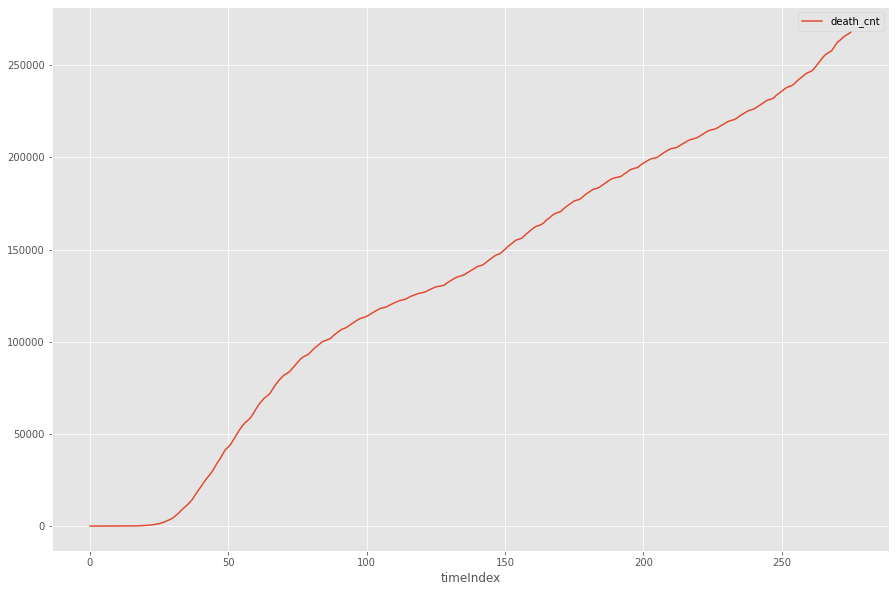

In [88]:
dfB.plot(kind="line", x="timeIndex", y = ["death_cnt"]) #choose 'case_cnt' or 'death_cnt' based on the problem

In [89]:
df_inp = dfB.death_cnt #choose 'case_cnt' or 'death_cnt' based on the problem

In [90]:
# univariate data preparation
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# # choose a number of time steps
# n_steps = 7
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)


####Vanilla LSTM

In [91]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
raw_seq = array(df_inp[:-30])
# choose a number of time steps
n_steps = 7
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(20, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)


In [92]:
# prediction
y_pred = []
x = array(df_inp[-37:-30])
for i in range(30):
  x_input = x.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  y_pred.append(yhat)
  x = list(x)
  x = x[1:] + [int(yhat)]
  x = array(x)
# y_pred

In [93]:
proj = list(df_inp[:-len(y_pred)]) + [int(y_pred[x][0]) for x in range(len(y_pred))]
proj = array(proj)

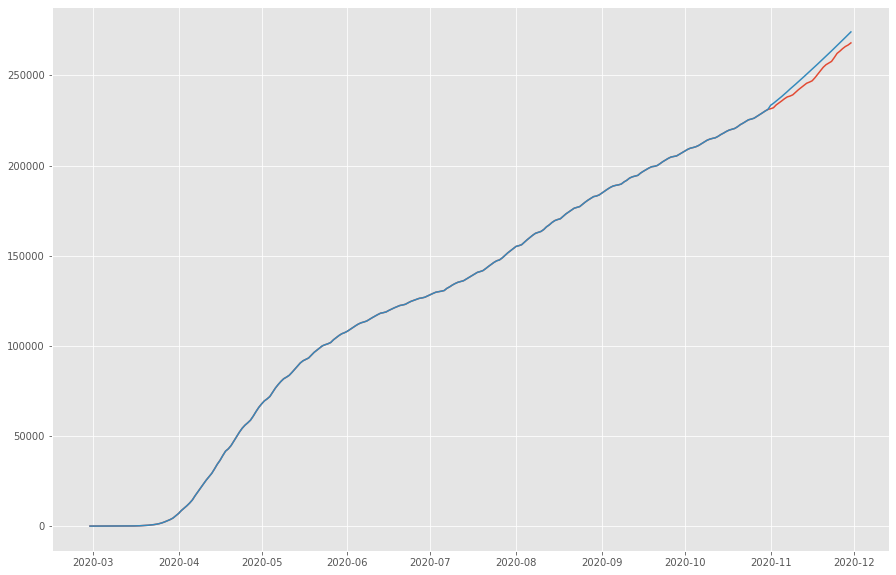

In [94]:
fig, ax = plt.subplots()
ax.plot(dfB.date, df_inp)
ax.plot(dfB.date, proj)

####Stacked LSTM

In [96]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
raw_seq = array(df_inp[:-30])
# choose a number of time steps
n_steps = 7
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
model = Sequential()
model.add(LSTM(20, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [97]:
# prediction
y_pred = []
x = array(df_inp[-37:-30])
for i in range(30):
  # x_input = X_test[i,:]
  x_input = x.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  y_pred.append(yhat)
  x = list(x)
  x = x[1:] + [int(yhat)]
  x = array(x)
# y_pred

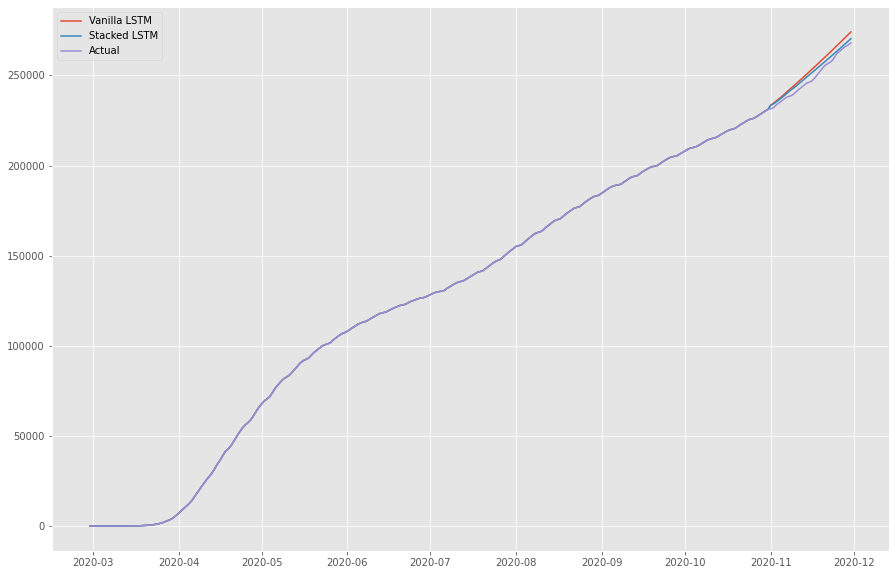

In [98]:
proj1 = list(df_inp[:-len(y_pred)]) + [int(y_pred[x][0]) for x in range(len(y_pred))]
proj1 = array(proj1)

plt.plot(dfB.date, proj, label='Vanilla LSTM')
plt.plot(dfB.date, proj1, label='Stacked LSTM')
plt.plot(dfB.date, df_inp, label='Actual')
plt.legend()

####Bidirectional LSTM

In [99]:
from keras.layers import Bidirectional
# define model
model = Sequential()
model.add(Bidirectional(LSTM(20, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [100]:
# prediction
y_pred = []
x = array(df_inp[-37:-30])
for i in range(30):
  x_input = x.reshape((1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  y_pred.append(yhat)
  x = list(x)
  x = x[1:] + [int(yhat)]
  x = array(x)

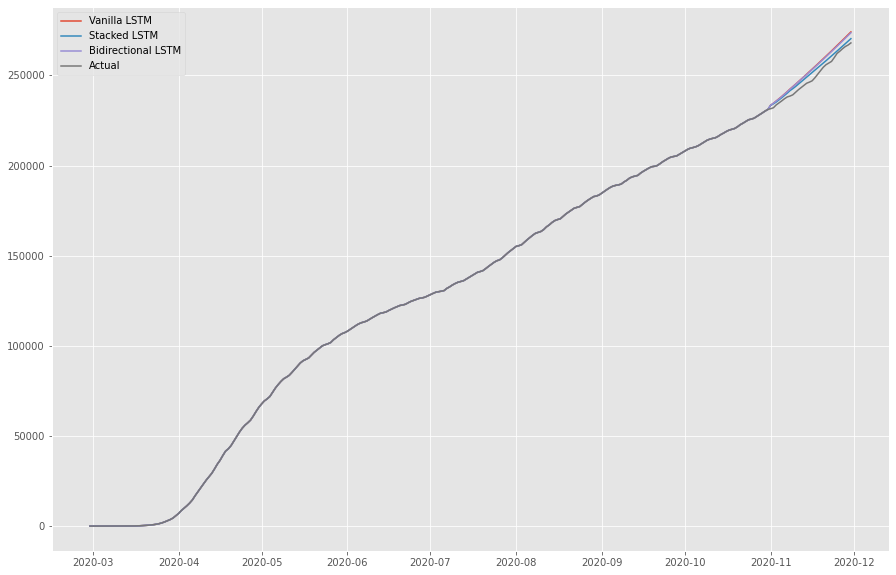

In [101]:
proj2 = list(df_inp[:-len(y_pred)]) + [int(y_pred[x][0]) for x in range(len(y_pred))]
proj2 = array(proj2)

plt.plot(dfB.date, proj, label='Vanilla LSTM')
plt.plot(dfB.date, proj1, label='Stacked LSTM')
plt.plot(dfB.date, proj2, label='Bidirectional LSTM')
plt.plot(dfB.date, df_inp, label='Actual')
plt.legend()

####CNN+LSTM

In [105]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps = 6
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 3
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)

In [106]:
y_pred = []
x = array(df_inp[-36:-30])
for i in range(30):
  # x_input = X_test[i,:]
  x_input = x.reshape((1, n_seq, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  y_pred.append(yhat)
  x = list(x)
  x = x[1:] + [int(yhat)]
  x = array(x)

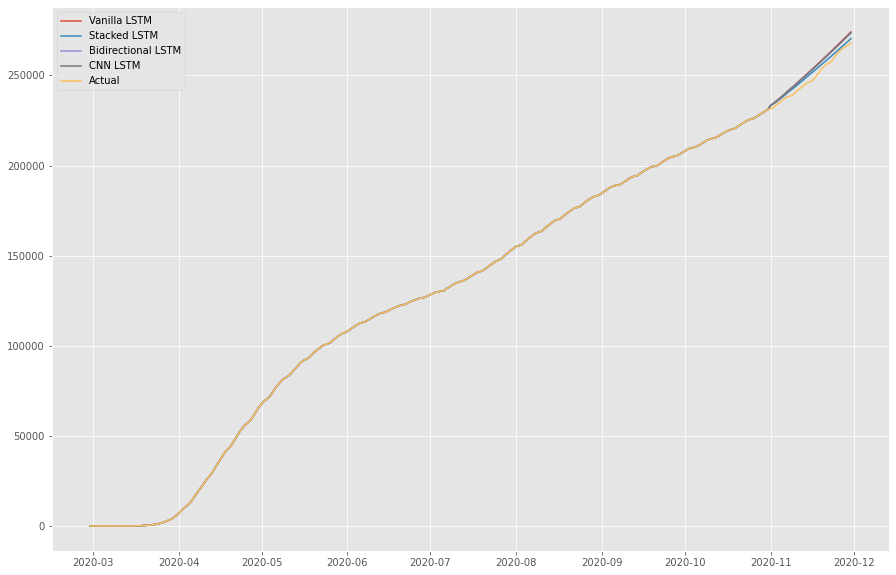

In [107]:
proj3 = list(df_inp[:-len(y_pred)]) + [int(y_pred[x][0]) for x in range(len(y_pred))]
proj3 = array(proj3)

plt.plot(dfB.date, proj, label='Vanilla LSTM')
plt.plot(dfB.date, proj1, label='Stacked LSTM')
plt.plot(dfB.date, proj2, label='Bidirectional LSTM')
plt.plot(dfB.date, proj3, label='CNN LSTM')
plt.plot(dfB.date, df_inp, label='Actual')
plt.legend()

####ConvLSTM

In [119]:
from keras.layers import ConvLSTM2D
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# choose a number of time steps
n_steps = 6
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 3
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)

In [120]:
# prediction
y_pred = []
x = array(df_inp[-36:-30])
for i in range(30):
  x_input = x.reshape((1, n_seq, 1, n_steps, n_features))
  yhat = model.predict(x_input, verbose=0)
  y_pred.append(yhat)
  x = list(x)
  x = x[1:] + [int(yhat)]
  x = array(x)

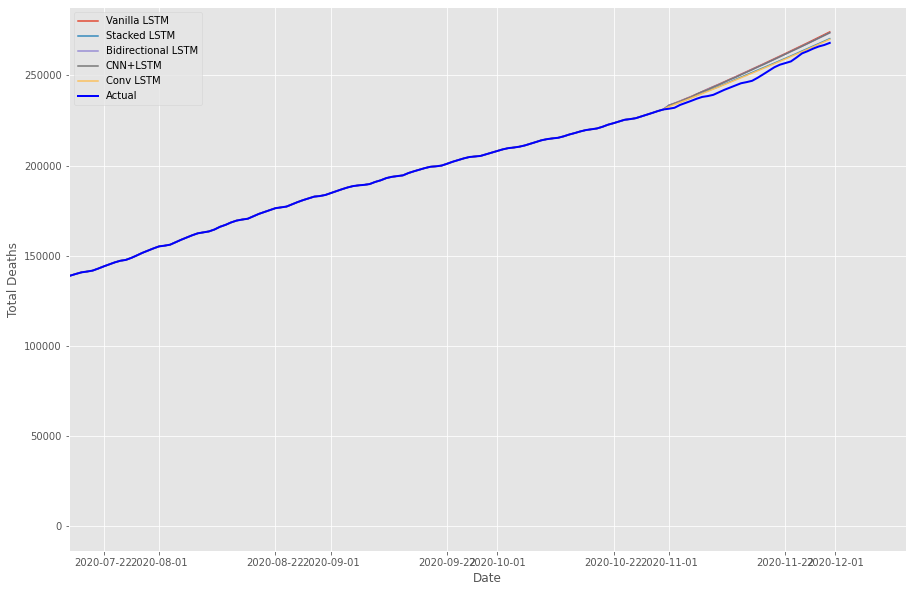

In [121]:
proj4 = list(df_inp[:-len(y_pred)]) + [int(y_pred[x][0]) for x in range(len(y_pred))]
proj4 = array(proj4)

plt.plot(dfB.date, proj, label='Vanilla LSTM')
plt.plot(dfB.date, proj1, label='Stacked LSTM')
plt.plot(dfB.date, proj2, label='Bidirectional LSTM')
plt.plot(dfB.date, proj3, label='CNN+LSTM')
plt.plot(dfB.date, proj4, label='Conv LSTM')
plt.plot(dfB.date, df_inp, label='Actual', color = 'blue', linewidth=2)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Deaths')
B = plt.xlim()
L = B[1] - B[0]
plt.xlim(B[1] - int(L/2), B[1])
plt.show()

In [122]:
act = array(dfB['death_daily'])
act = act[1:]
date = array(dfB.date)
date = date[1:]

In [123]:
# Daily Projections
daily_proj = proj[1:] - proj[:-1]
daily_proj1 = proj1[1:] - proj1[:-1]
daily_proj2 = proj2[1:] - proj2[:-1]
daily_proj3 = proj3[1:] - proj3[:-1]
daily_proj4 = proj4[1:] - proj4[:-1]

daily_proj[-30] = act[-30]
daily_proj1[-30] = act[-30]
daily_proj2[-30] = act[-30]
daily_proj3[-30] = act[-30]
daily_proj4[-30] = act[-30]

In [117]:
def mov_avg(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

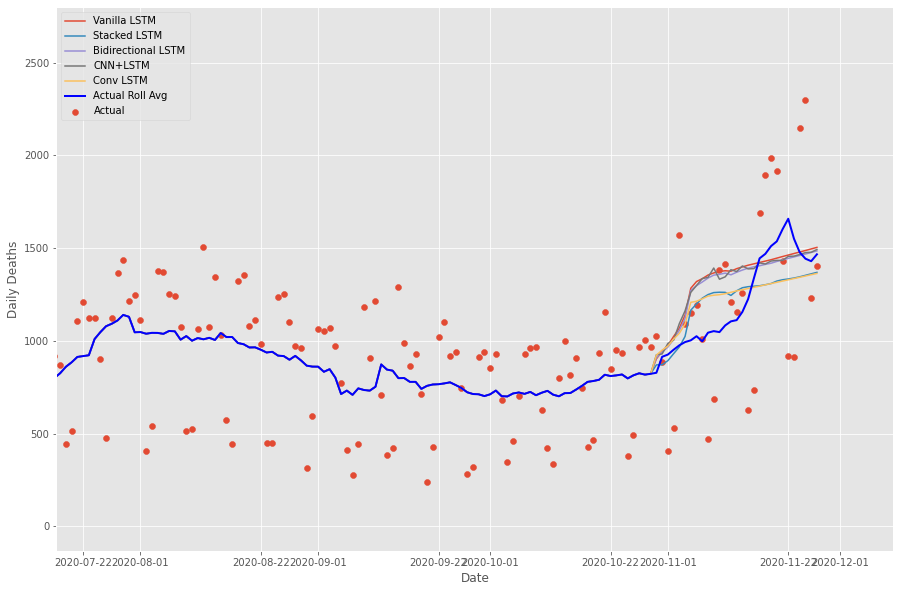

In [124]:
plt.plot(date[3:-3], mov_avg(daily_proj,7), label='Vanilla LSTM')
plt.plot(date[3:-3], mov_avg(daily_proj1,7), label='Stacked LSTM')
plt.plot(date[3:-3], mov_avg(daily_proj2,7), label='Bidirectional LSTM')
plt.plot(date[3:-3], mov_avg(daily_proj3,7), label='CNN+LSTM')
plt.plot(date[3:-3], mov_avg(daily_proj4,7), label='Conv LSTM')
plt.plot(date[3:-3], mov_avg(act,7), label='Actual Roll Avg', color = 'blue', linewidth = 2)
plt.scatter(date[3:-3], act[3:-3], label='Actual')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Daily Deaths')
B = plt.xlim()
L = B[1] - B[0]
plt.xlim(B[1] - int(L/2), B[1])
plt.show()

####RMSE

In [125]:
P = mov_avg(daily_proj,7)
P1 = mov_avg(daily_proj1,7)
P2 = mov_avg(daily_proj2,7)
P3 = mov_avg(daily_proj3,7)
P4 = mov_avg(daily_proj4,7)
A = mov_avg(act,7)

In [126]:
import math
def RMSE(predicted, actual):
    P = []
    A = []
    for i in range(len(predicted)):
      if math.isnan(predicted[i]) or math.isnan(actual[i]):
        continue
      P.append(predicted[i])
      A.append(actual[i])
    mse = (np.array(P) - np.array(A))**2
    rmse = np.sqrt(np.sum(mse)/len(mse))
    return rmse

In [127]:
dfR = pd.DataFrame(columns=['Model','RMSE'])
dfR.loc[0,"Model"] = "Vanilla LSTM"
dfR.loc[0,"RMSE"] = RMSE(P[-30:],A[-30:])

dfR.loc[1,"Model"] = "Stacked LSTM"
dfR.loc[1,"RMSE"] = RMSE(P1[-30:],A[-30:])

dfR.loc[2,"Model"] = "Bidirectional LSTM"
dfR.loc[2,"RMSE"] = RMSE(P2[-30:],A[-30:])

dfR.loc[3,"Model"] = "CNN+LSTM"
dfR.loc[3,"RMSE"] = RMSE(P3[-30:],A[-30:])

dfR.loc[4,"Model"] = "ConvLSTM"
dfR.loc[4,"RMSE"] = RMSE(P4[-30:],A[-30:])

dfR

,Model,RMSE
0,Vanilla LSTM,187.085
1,Stacked LSTM,157.924
2,Bidirectional LSTM,178.935
3,CNN+LSTM,183.302
4,ConvLSTM,162.348
